In [2]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from utils import EnhancerDataset, split_dataset, train_model, regression_model_plot, plot_filter_weight
import pandas as pd
import os 

import sys
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import interpretation
import seaborn as sns
import matplotlib.pyplot as plt
import tools
import logomaker
import math


sys.path.append('../model')  
from model import ConvNetDeep, DanQ, ExplaiNN,ConvNetDeep2, ExplaiNN2, ExplaiNN3

In [3]:
def find_all_motifs(sequence, motif):
    """Find all occurrences of a motif in the sequence, returning start and end positions."""
    start = 0
    motif_length = len(motif)
    while True:
        start = sequence.find(motif, start)
        if start == -1:
            break
        end = start + motif_length
        yield (start, end)
        start += 1  # Move start forward for next search to allow overlapping motifs

def calculate_motif_distance_score(sequence, motif1, motif2, eps=1e-6):
    """Calculate the total score based on the closest pair distances between two motifs in a sequence."""
    motifs1 = list(find_all_motifs(sequence, motif1))
    motifs2 = list(find_all_motifs(sequence, motif2))
    total_score = 0

    # If either motif list is empty, return a score of 1
    if not motifs1 or not motifs2:
        return 1

    # Use a simple greedy approach to find the closest pair
    while motifs1 and motifs2:
        # Find the pair with the minimum distance
        min_distance = float('inf')
        best_pair = None
        for i, (start1, end1) in enumerate(motifs1):
            for j, (start2, end2) in enumerate(motifs2):
                if end1 <= start2:
                    distance = start2 - end1
                elif end2 <= start1:
                    distance = start1 - end2
                else:
                    overlap_start = max(start1, start2)
                    overlap_end = min(end1, end2)
                    overlap_length = overlap_end - overlap_start
                    longer_motif_length = max(end1 - start1, end2 - start2)
                    distance = overlap_length / longer_motif_length
                
                if distance < min_distance:
                    min_distance = distance
                    best_pair = (i, j)

        # Calculate the score for the best pair and remove the paired motifs
        if best_pair:
            i, j = best_pair
            A, B = 1, 1  # Since both motifs exist
            score = math.exp(A * B * (1 / (min_distance + eps)))
            total_score += score
            # Remove paired motifs
            del motifs1[i]
            del motifs2[j]

    return total_score

# Example usage
sequence = "motif1 here and there motif2, again motif1 close to another motif2"
motif1 = "motif1"
motif2 = "motif2"
score = calculate_motif_distance_score(sequence, motif1, motif2)
print(f"Total distance score for the closest pairs: {score}")


seed = 42 
batch = 322
num_cnns = 90
learning_rate= 2e-4
filter_size = 19
motif1 = 'GCGGG'
motif2 = 'CATCT'
target_labels = ["GFP+", "GFP-","Motif Distance Score"]

Total distance score for the closest pairs: 2.15183948465601


### Train Model

In [4]:
# Directory to save the result
output_dir = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_distance_results'

df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/input_data.csv')
df['distance'] = df['sequence'].apply(lambda x: calculate_motif_distance_score(x, motif1, motif2))

#train, test = split_dataset(df, split_type='fragment', key= 0, seed = 42)
train, test = split_dataset(df, split_type='random', cutoff = 0.8, seed = seed)

# Process datasets
train = EnhancerDataset(train, label_mode='distance', scale_mode = 'none')
test = EnhancerDataset(test, label_mode='distance', scale_mode = 'none')

# DataLoader setup
train_loader = DataLoader(dataset=train, batch_size=batch, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=batch, shuffle=True)

#input_model = ExplaiNN2(num_cnns = 256, input_length = 608, num_classes = 2, 
#                 filter_size = 19, num_fc=2, pool_size=7, pool_stride=7, 
#                 fc_filter1 = 20, fc_filter2 = 1, drop_out = 0.3, weight_path = None)# Training

input_model = ExplaiNN3(num_cnns = num_cnns, input_length = 608, num_classes = 3, 
                 filter_size = 19, num_fc=2, pool_size=7, pool_stride=7, 
                 drop_out = 0.3, weight_path = None)# Training

_, _, model, train_losses_by_batch, test_losses_by_batch, results, best_pearson_epoch, best_r2_epoch, device  = train_model(input_model, train_loader, test_loader, 
                                                                                                                            target_labels=target_labels,num_epochs=200, 
                                                                                                                        batch_size=batch, learning_rate=learning_rate, 
                                                                                                                        criteria='mse',optimizer_type = "adam", patience=10, 
                                                                                                                        seed = seed, save_model= True, dir_path=output_dir)

Using device: cuda
Model is on device: cuda:0
Epoch 1/200, Step 1/72, Loss: 47.7596
Epoch 1/200: Train Loss: 43.9648 , Test Loss: 42.0466
------------------------Evaluation------------------------
Label 1: MSE=63.2890, RMSE=7.9554, MAE=7.9498, R^2=-805.7080, Pearson=0.2888, Spearman=0.2843
Label 2: MSE=62.2941, RMSE=7.8927, MAE=7.8875, R^2=-1222.5456, Pearson=0.0562, Spearman=0.0623
Label 3: MSE=0.5569, RMSE=0.7462, MAE=0.7051, R^2=-7.0943, Pearson=0.5272, Spearman=0.6545
Overall (Flattened): MSE=42.0466, RMSE=6.4843, MAE=5.5142, R^2=-2.4123, Pearson=0.4374, Spearman=0.4830
----------------------------------------------------------
Epoch 2/200, Step 1/72, Loss: 40.4645
Epoch 2/200: Train Loss: 37.3256 , Test Loss: 35.9083
------------------------Evaluation------------------------
Label 1: MSE=54.6488, RMSE=7.3925, MAE=7.3865, R^2=-695.5769, Pearson=0.3720, Spearman=0.3699
Label 2: MSE=52.8660, RMSE=7.2709, MAE=7.2654, R^2=-1037.3635, Pearson=0.1629, Spearman=0.1666
Label 3: MSE=0.2043,

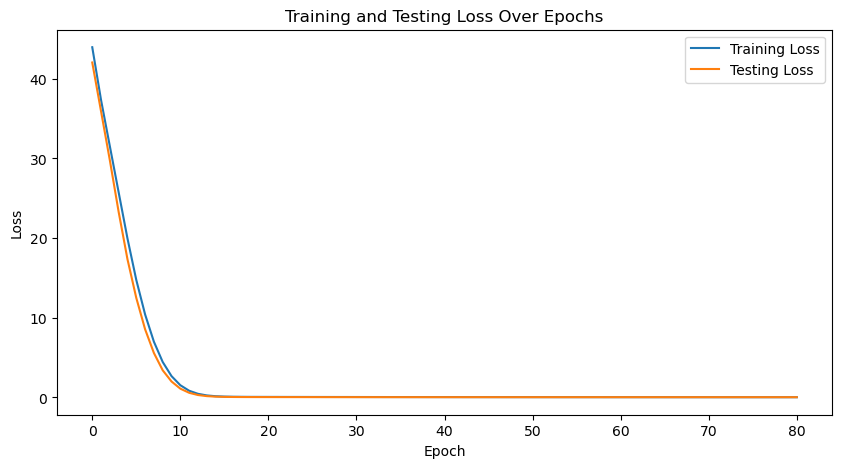

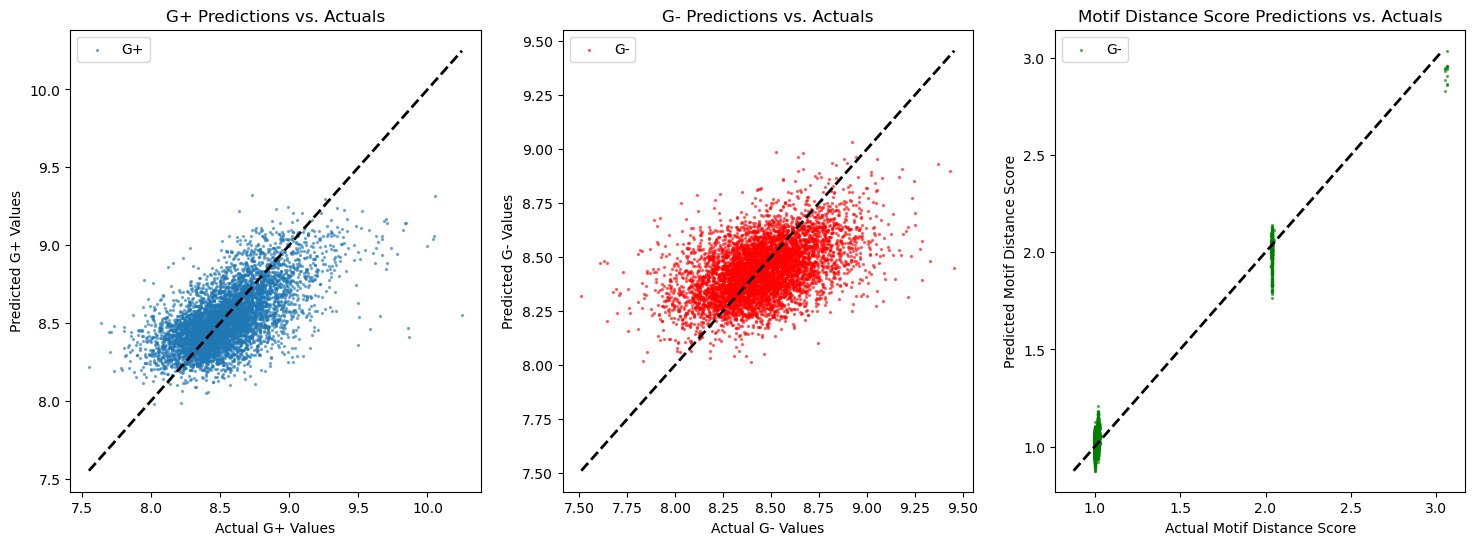

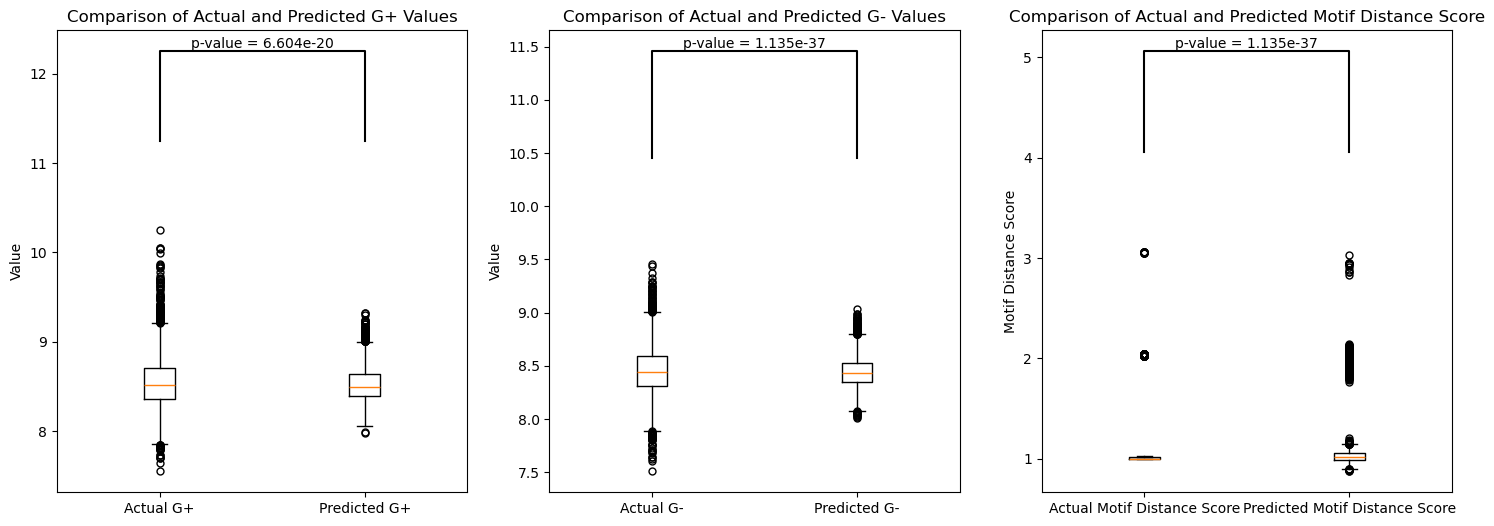

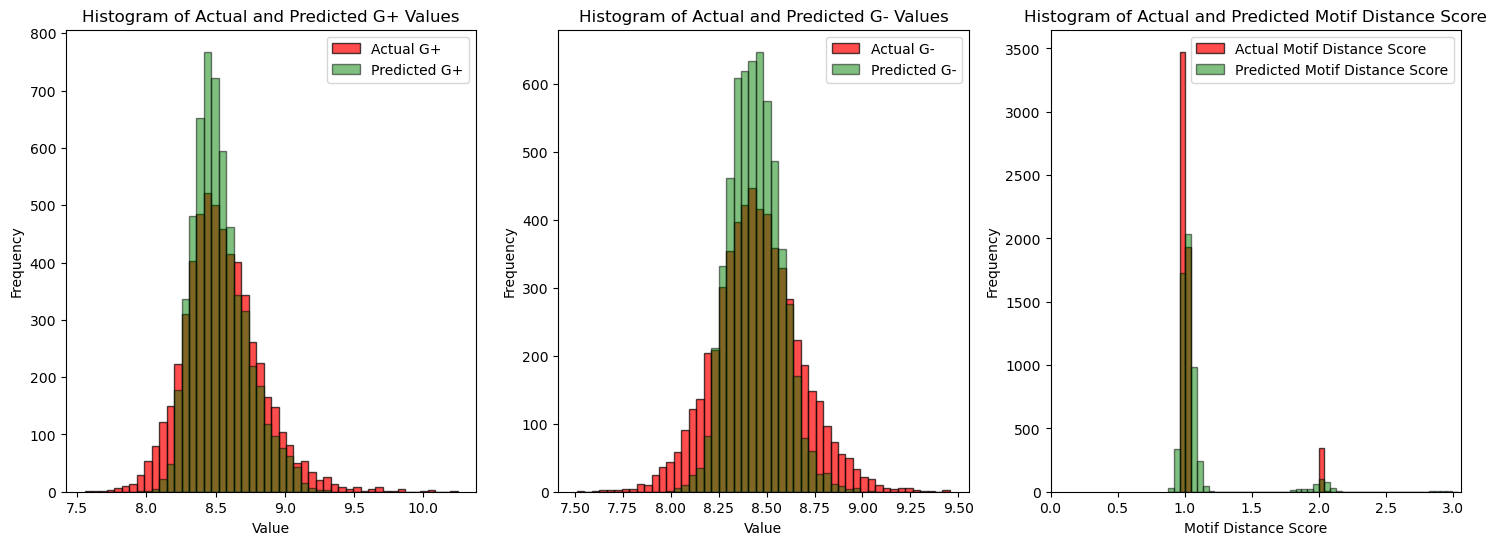

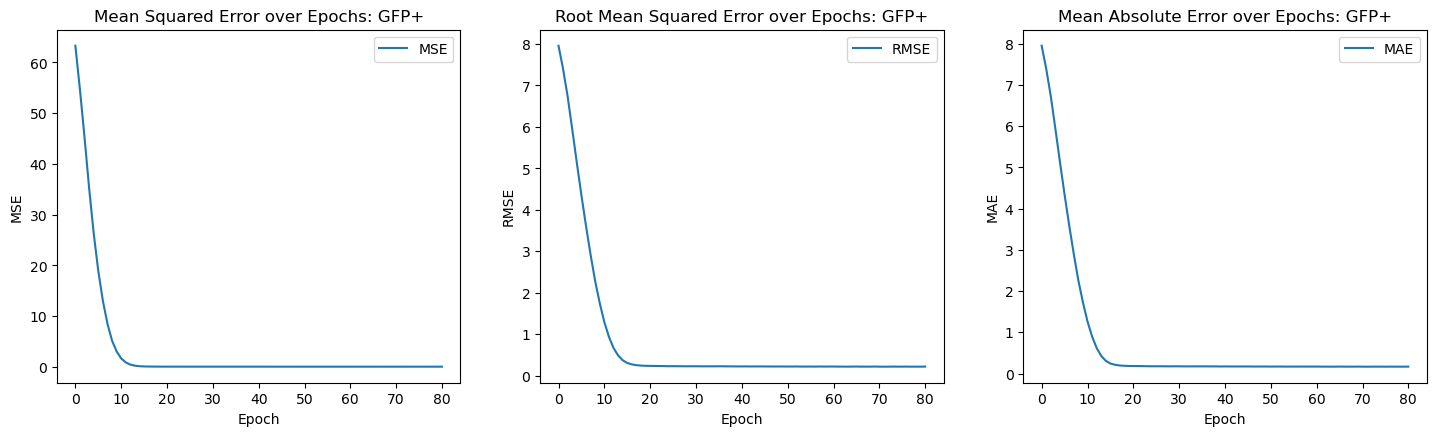

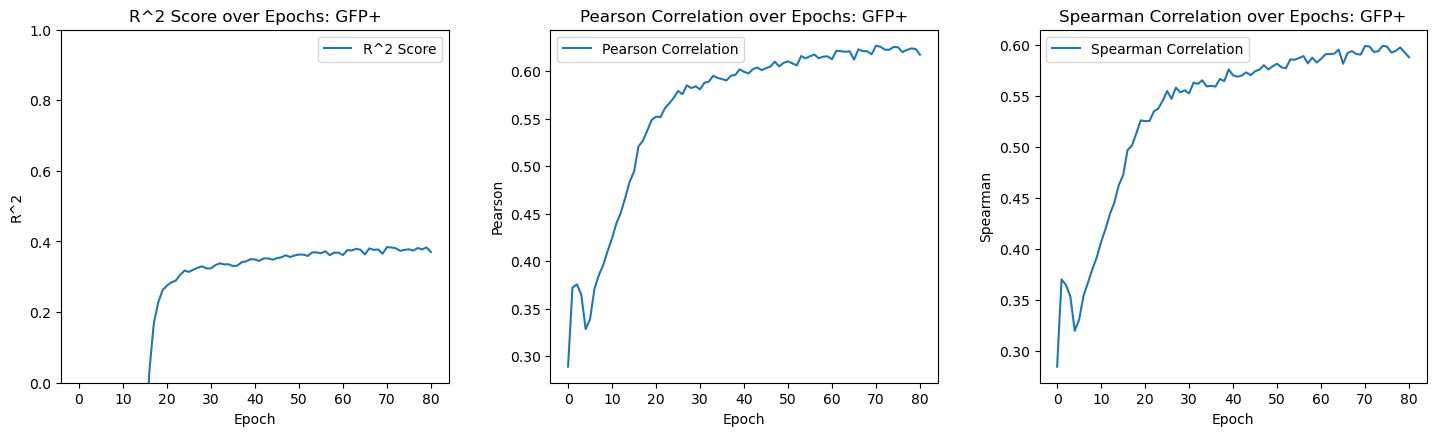

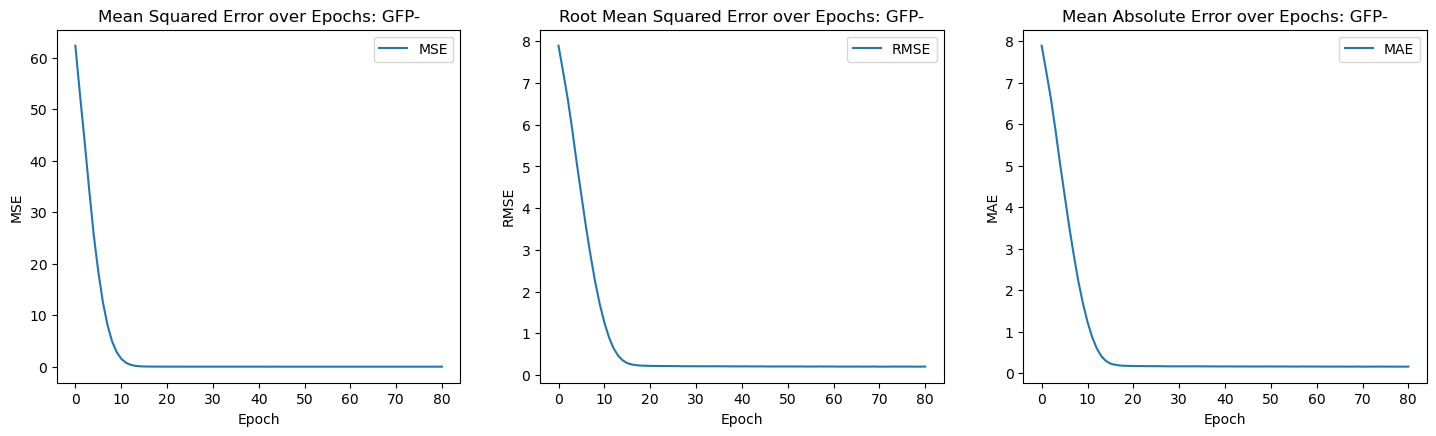

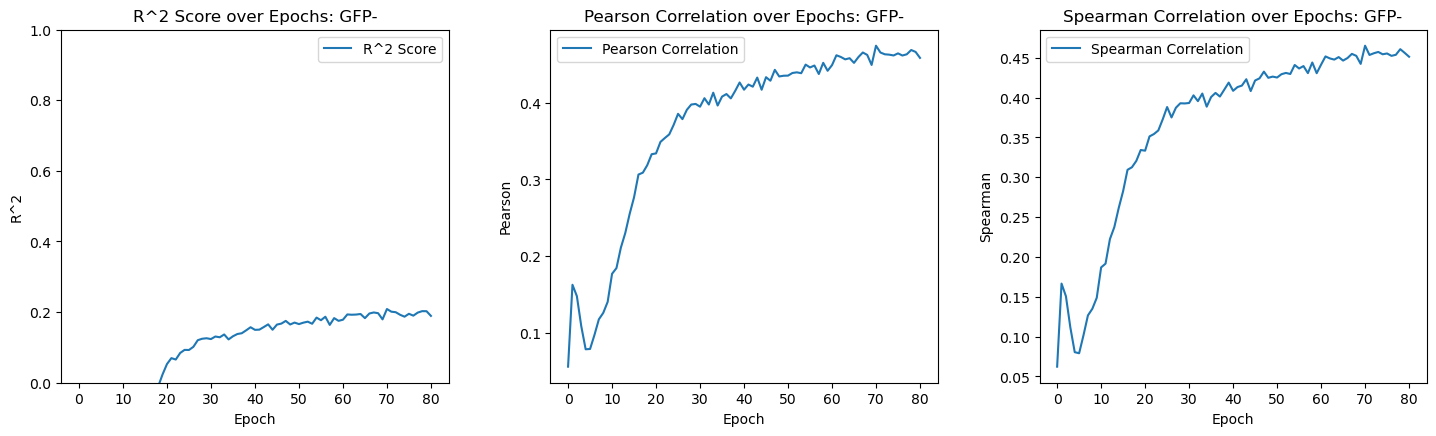

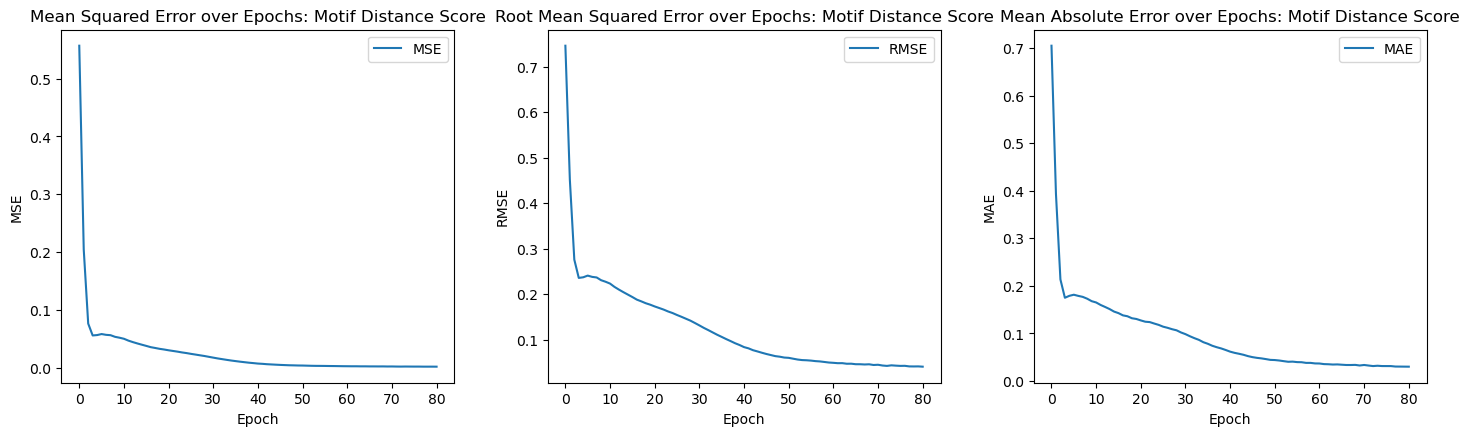

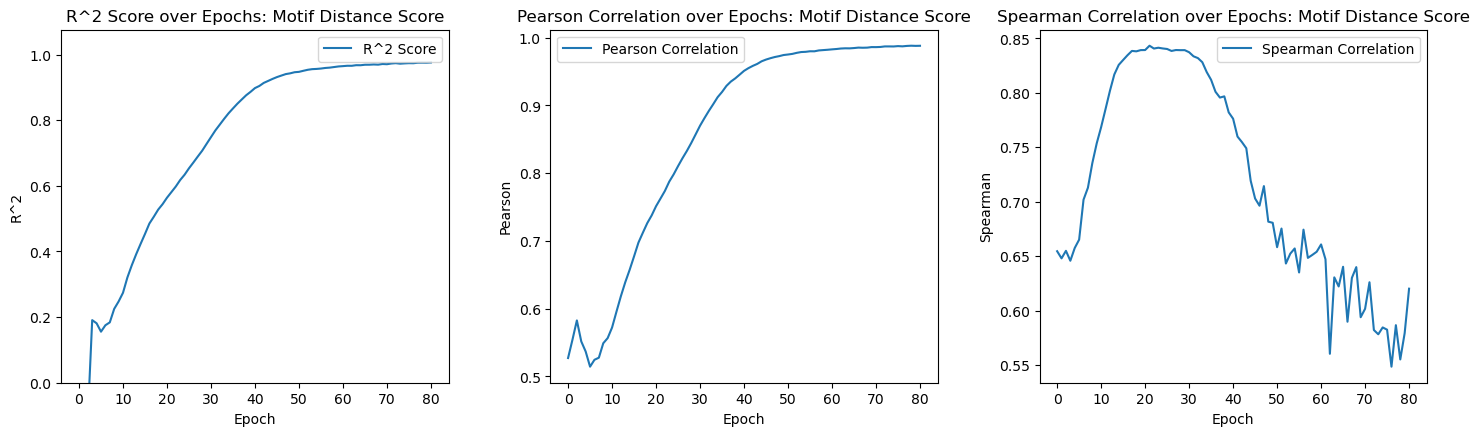

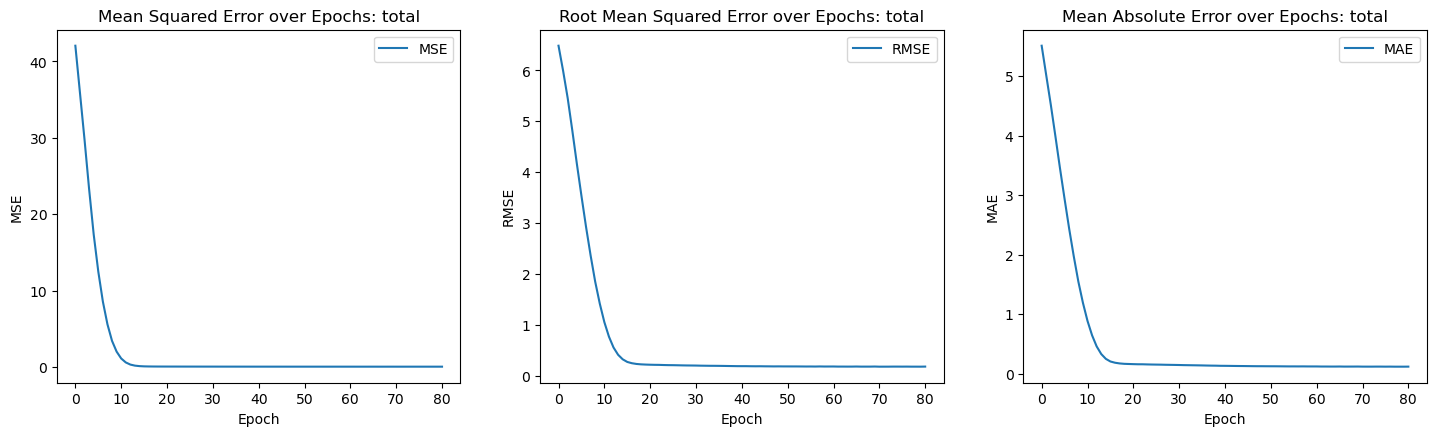

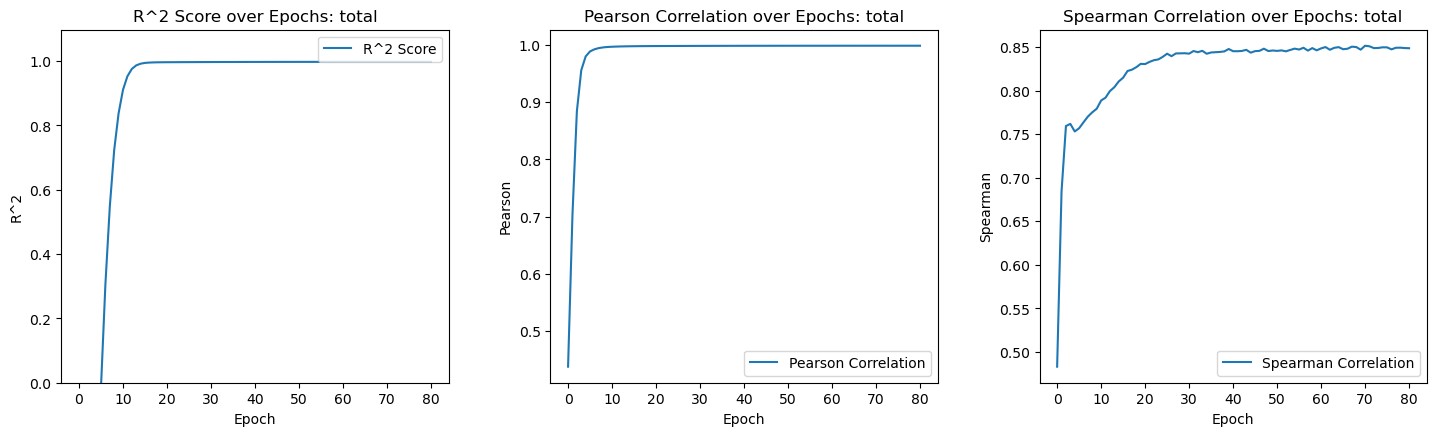

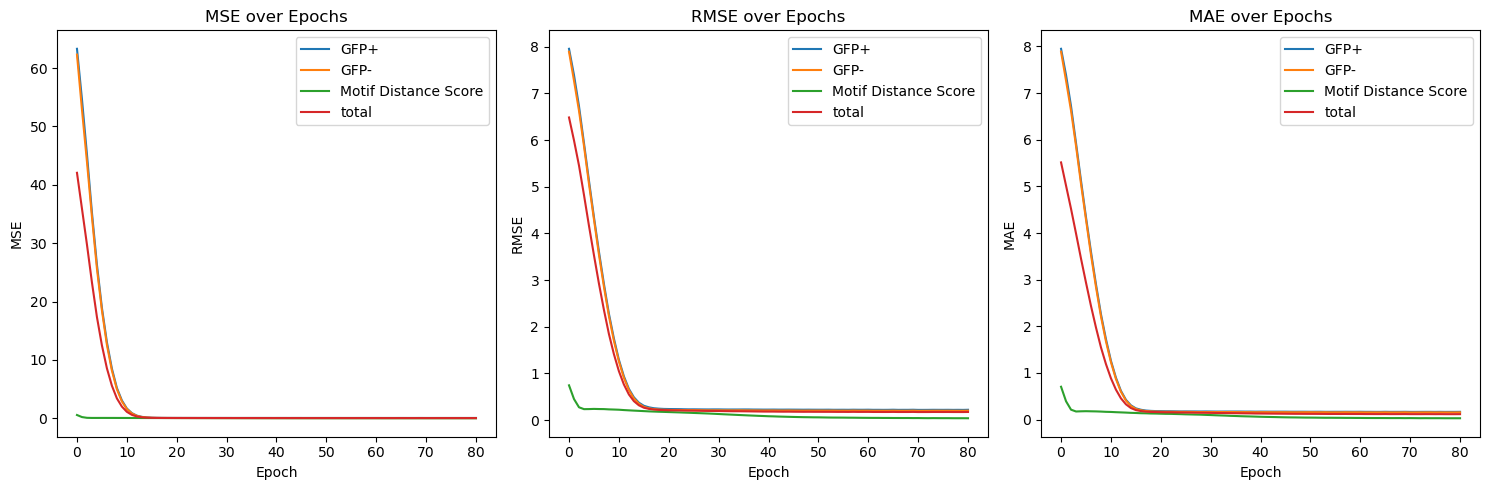

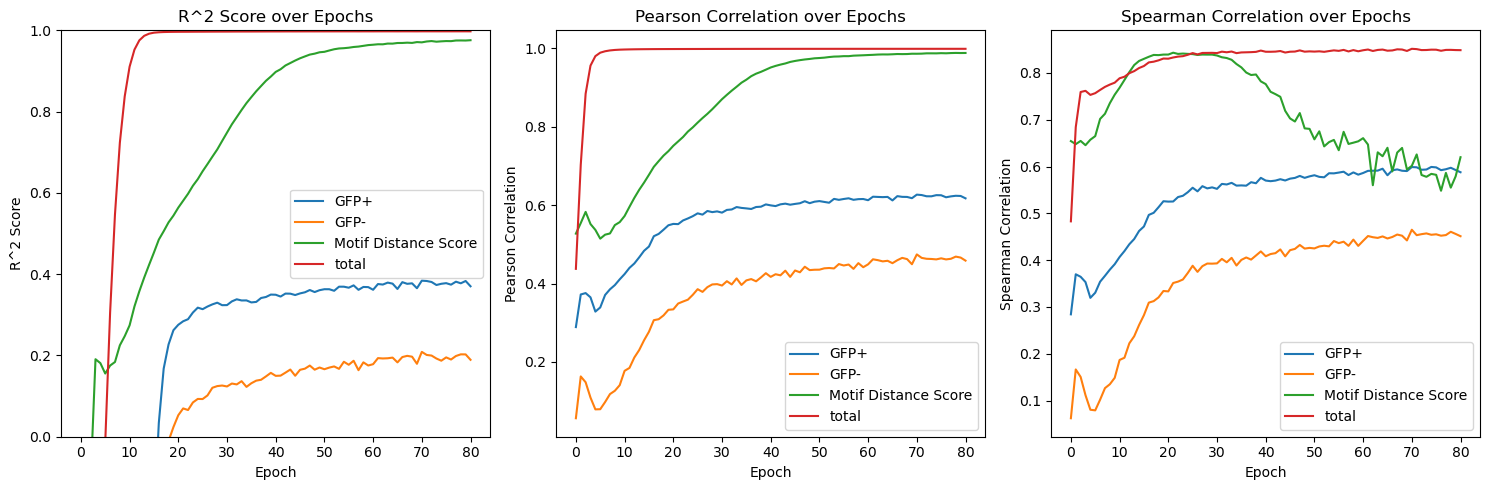

MSE: 0.0308, RMSE: 0.1755, MAE: 0.1179
R^2: 0.9975, Pearson Correlation: 0.9988, Spearman Correlation: 0.8488


In [5]:
#best_r2_epoch = 96
model_path = f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_distance_results/model_epoch_{best_r2_epoch}.pth'

mse, rmse, mae, r2, pearson_corr, spearman_corr = regression_model_plot(
    model, test_loader, train_losses_by_batch, test_losses_by_batch, 
    device, results, label_mode = "distance", save_plot = False, dir_path = None, model_path = model_path, best_model=best_r2_epoch)

print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}, Pearson Correlation: {pearson_corr:.4f}, Spearman Correlation: {spearman_corr:.4f}")

### Interpretation

In [5]:
best_r2_epoch = 71
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
explainn = ExplaiNN3(num_cnns = num_cnns, input_length = 608, num_classes = 3, 
                 filter_size = filter_size, num_fc=2, pool_size=7, pool_stride=7, 
                 drop_out = 0.3, weight_path = None)# Training
explainn.to(device)  

weight_file = f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_distance_results/model_epoch_{best_r2_epoch}.pth'
explainn.load_state_dict(torch.load(weight_file))
explainn.eval()

ExplaiNN3(
  (linears): Sequential(
    (0): Conv1d(360, 90, kernel_size=(19,), stride=(1,), groups=90)
    (1): BatchNorm1d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ExpActivation()
    (3): MaxPool1d(kernel_size=7, stride=7, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Unsqueeze()
    (6): Conv1d(7560, 9000, kernel_size=(1,), stride=(1,), groups=90)
    (7): BatchNorm1d(9000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Dropout(p=0.3, inplace=False)
    (10): Conv1d(9000, 90, kernel_size=(1,), stride=(1,), groups=90)
    (11): BatchNorm1d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Flatten(start_dim=1, end_dim=-1)
  )
  (final): Linear(in_features=90, out_features=3, bias=True)
)

In [6]:
# Load dataset as a pandas dataframe
df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/input_data.csv')
df['distance'] = df['sequence'].apply(lambda x: calculate_motif_distance_score(x, motif1, motif2))

# Prepare features and labels:
# --(Features): Transform all sequences into one-hot encodings
# --(Labels): Use GFP+ and GFP- as labels
dataset = EnhancerDataset(df, label_mode='both', scale_mode = 'none')
# Prepare dataloader
dataset = DataLoader(dataset=dataset, batch_size=batch, shuffle=False)

# Running get_explainn_predictions function to get predictions and true labels for all sequences in the given data loader
predictions, labels = interpretation.get_explainn_predictions(dataset, explainn, device, isSigmoid=False)
print(predictions.shape)

(28800, 3)


Number of samples before filtering: 28800
torch.Size([6676, 4, 608])
torch.Size([6676, 3])
Number of samples after filtering: 6676


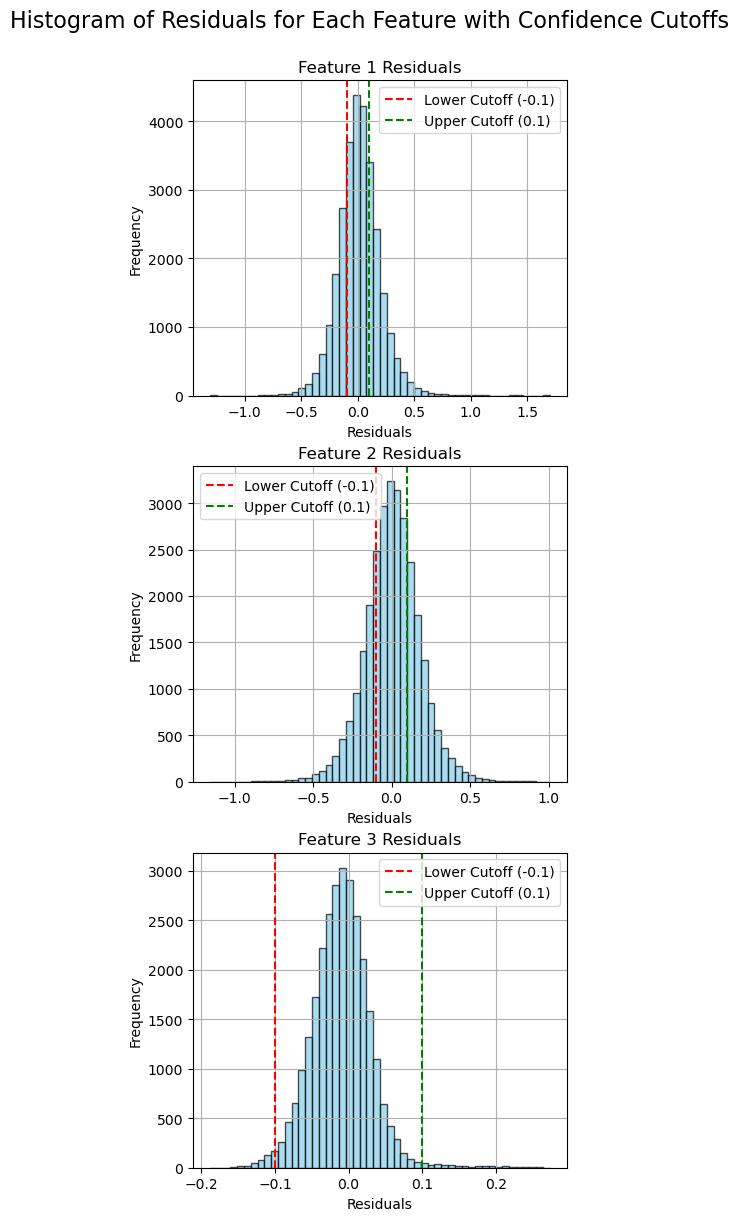

In [7]:
# Load dataset as a pandas dataframe
df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/input_data.csv')
df['distance'] = df['sequence'].apply(lambda x: calculate_motif_distance_score(x, motif1, motif2))

# Prepare features and labels:
# --(Features): Transform all sequences into one-hot encodings
# --(Labels): Use GFP+ and GFP- as labels
dataset = EnhancerDataset(df, label_mode='distance', scale_mode = 'none')
# Prepare dataloader
dataset = DataLoader(dataset=dataset, batch_size=batch, shuffle=False)

# Running get_explainn_predictions function to get predictions and true labels for all sequences in the given data loader
predictions, labels = interpretation.get_explainn_predictions(dataset, explainn, device, isSigmoid=False)

"""Now filter out low confident predictions"""
# Calculate absolute residuals
residuals = np.abs(labels - predictions)

# Define the upper bound of residuals
upper_bound = 0.1

# Create a mask for filtering out samples with low confident precition (abs(residual) > upper_bound)
mask = (residuals <= upper_bound).all(axis=1)

# Get sequences and labels from dataset
data_inp = []
data_out = []
# Iterate over the DataLoader
for batch_features, batch_labels in dataset:
    data_inp.append(batch_features)
    data_out.append(batch_labels)
# Concatenate all the batches into single tensors
data_inp = torch.cat(data_inp, dim=0)
data_out = torch.cat(data_out, dim=0)

# Use the mask to filter the predictions and labels
print(f'Number of samples before filtering: {len(data_inp)}')
data_inp = data_inp[mask]
data_out = data_out[mask]
print(data_inp.shape)
print(data_out.shape)

print(f'Number of samples after filtering: {len(data_inp)}')

# Create new dataloader with filtered high confident samples
dataset = torch.utils.data.TensorDataset(data_inp, data_out)
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch, shuffle=False,)

# Plot histogram of residuals with adjusted cutoff lines
# 1. Compute residuals (not absolute)
residuals = labels - predictions

# 2. Define bounds for plotting
upper_bound = 0.1
lower_bound = -0.1

# 3.Plotting the histograms for each feature
fig, axes = plt.subplots(nrows=predictions.shape[1], ncols=1, figsize=(5, 4*predictions.shape[1]))
fig.tight_layout(pad=3.0)

# Title for the entire figure
fig.suptitle('Histogram of Residuals for Each Feature with Confidence Cutoffs', fontsize=16, y=1.02)

for i in range(predictions.shape[1]):
    ax = axes[i]
    ax.hist(residuals[:, i], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    ax.axvline(x=lower_bound, color='red', linestyle='--', label=f'Lower Cutoff ({lower_bound})')
    ax.axvline(x=upper_bound, color='green', linestyle='--', label=f'Upper Cutoff ({upper_bound})')
    ax.set_title(f'Feature {i+1} Residuals')
    ax.set_xlabel('Residuals')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True)

plt.show()

In [9]:
""" ！！！！！！！！！！！！
You don't need to run this if you already calculated activations and pwms before
"""
# Get weights from activation layer
activations = interpretation.get_explainn_unit_activations(data_loader, explainn, device)
print(f"Activations have shape: {activations.shape}")
# Save activations
activation_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/90CNN_distance_Activations.npy'
np.save(activation_path, activations)

# Get torch,  one-hot encoding sequences from data_loader
sequences = []
# Iterate over the DataLoader
for batch in data_loader:
    batch_sequences = batch[0]  
    sequences.append(batch_sequences)
sequences = torch.cat(sequences, dim=0)

# Define filter size. This parameter should be consistent with filter_size used in ExplaiNN
filter_size = 19
pwms = interpretation.get_pwms_explainn(activations, sequences, filter_size)

# Save pwms
pwm_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/90CNN_distance_pwms.npy'
np.save(pwm_path, pwms)

100%|████████████████████| 21/21 [00:01<00:00, 14.57it/s]


Activations have shape: (6676, 90, 590)


100%|████████████████████| 90/90 [00:13<00:00,  6.72it/s]


In [8]:
pwm_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/90CNN_distance_pwms.npy'
activation_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/90CNN_distance_Activations.npy'
pwm_name = '/pmglocal/ty2514/Enhancer/Enhancer/data/90CNN_distance_TFBS.meme'
activations = np.load(activation_path)
print(f"Activations have shape: {activations.shape}")
pwms = np.load(pwm_path)
print(f"PWMs have shape: {pwms.shape}")
interpretation.pwm_to_meme(pwms, pwm_name)

Activations have shape: (6676, 90, 590)
PWMs have shape: (90, 4, 19)
Saved PWM File as : /pmglocal/ty2514/Enhancer/Enhancer/data/90CNN_distance_TFBS.meme


In [ ]:
# Running tomtom to compare 100CNN_TFBS.meme with JASPAR2020_CORE_vertebrates_non-redundant_pfms_meme.txt
#%cd /pmglocal/ty2514/Enhancer
#!python ExplaiNN/scripts/utils/tomtom.py Enhancer/data/100CNN_TFBS.meme ExplaiNN/data/JASPAR/JASPAR2020_CORE_vertebrates_non-redundant_pfms_meme.txt -o Enhancer/tomtom_results/tomtom_CAM_100


In [44]:
tomtom_results = pd.read_csv("/pmglocal/ty2514/Enhancer/Enhancer/tomtom_2024results/tomtom_CAM_90NN_distance/tomtom.tsv",
                                        sep="\t",comment="#")
filters_with_min_q = tomtom_results.groupby('Query_ID').min()["q-value"]
tomtom_results = tomtom_results[["Target_ID", "Query_ID", "q-value"]]
tomtom_results = tomtom_results[tomtom_results["q-value"]<0.05]
cisbp_motifs = {}
with open("/pmglocal/ty2514/Enhancer/ExplaiNN/data/JASPAR/JASPAR2024_CORE_vertebrates_non-redundant_pfms_meme.txt") as f:
    for line in f:
        if "MOTIF" in line:
            motif = line.strip().split()[-1]
            name_m = line.strip().split()[-2]
            cisbp_motifs[name_m] = motif

filters = tomtom_results["Query_ID"].unique()
annotation = {}
for f in filters:
    t = tomtom_results[tomtom_results["Query_ID"] == f]
    target_id = t["Target_ID"]

    if len(target_id) > 5:
       target_id = target_id[:5]

    ###!!!!!!!!!!!!!
    target_id = target_id[:1]  ### If you only want to keep the most significant target_id, keep this line

    # Join Unique annotations by '/'
    ann = "/".join({cisbp_motifs[i]: i for i in target_id.values})
    annotation[f] = ann

annotation = pd.Series(annotation)
annotation

filter0            CTCF
filter1            CTCF
filter2            CTCF
filter3            CTCF
filter4            CTCF
filter5            CTCF
filter6            CTCF
filter8            CTCF
filter9            CTCF
filter12           CTCF
filter14           CTCF
filter15           CTCF
filter16           CTCF
filter17        ZNF354A
filter19           CTCF
filter20        ZNF354A
filter22           CTCF
filter24           CTCF
filter25           CTCF
filter27           CTCF
filter31           CTCF
filter34           CTCF
filter36           CTCF
filter41           CTCF
filter42           IRF3
filter43           CTCF
filter44           CTCF
filter46            SP5
filter49           CTCF
filter56           CTCF
filter57    PPARA::RXRA
filter59           CTCF
filter60           CTCF
filter61           CTCF
filter62           CTCF
filter65           CTCF
filter66           CTCF
filter67           CTCF
filter69           CTCF
filter70        ZNF354A
filter71           CTCF
filter73        

In [45]:
weights = explainn.final.weight.detach().cpu().numpy()
print(weights.shape)
num_cnns = 90
filters = ["filter"+str(i) for i in range(num_cnns)]
target_labels = ["GFP+","GFP-","Motif Distance Score"]

for i in annotation.keys():
    filters[int(i.split("filter")[-1])] = annotation[i]

weight_df = pd.DataFrame(weights, target_labels, columns=filters)
weight_df.shape
weight_df

(3, 90)


,CTCF,CTCF,CTCF,CTCF,CTCF,CTCF,CTCF,filter7,CTCF,CTCF,...,CTCF,filter81,CTCF,ZNF148,CTCF,CTCF,ZNF354A,CTCF,NFIA,RARA::RXRG
GFP+,0.160876,0.137038,0.196166,0.164940,0.166988,0.153090,0.203123,0.213675,0.088348,0.083402,...,0.143317,0.135860,0.223999,0.128492,0.237457,0.063956,0.202610,0.094312,0.170793,0.135833
GFP-,0.176298,0.135638,0.110886,0.214535,0.237004,0.159497,0.088510,0.186643,0.242743,0.207469,...,0.153241,0.186687,0.101170,0.158814,0.217475,0.113705,0.100167,0.158115,0.192101,0.066916
Motif Distance Score,0.103724,0.072654,0.024544,0.020850,0.037801,0.080693,0.210235,0.038872,0.049429,-0.045341,...,0.019806,-0.026328,0.053450,0.016275,0.025323,-0.069065,-0.065996,0.075810,0.053226,-0.069802


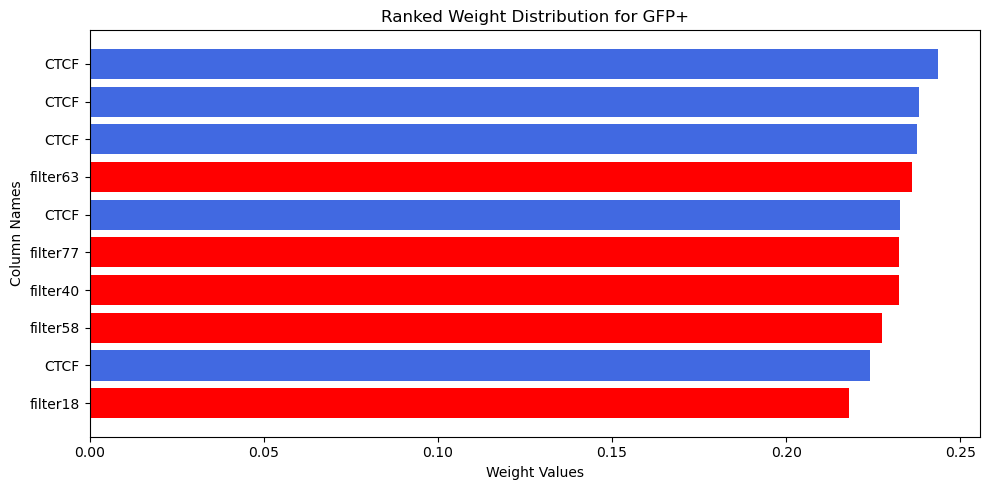

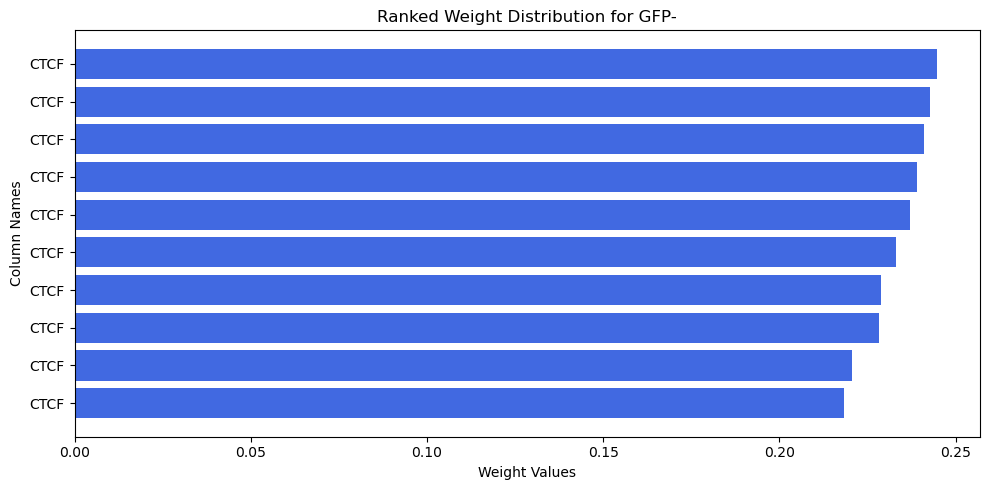

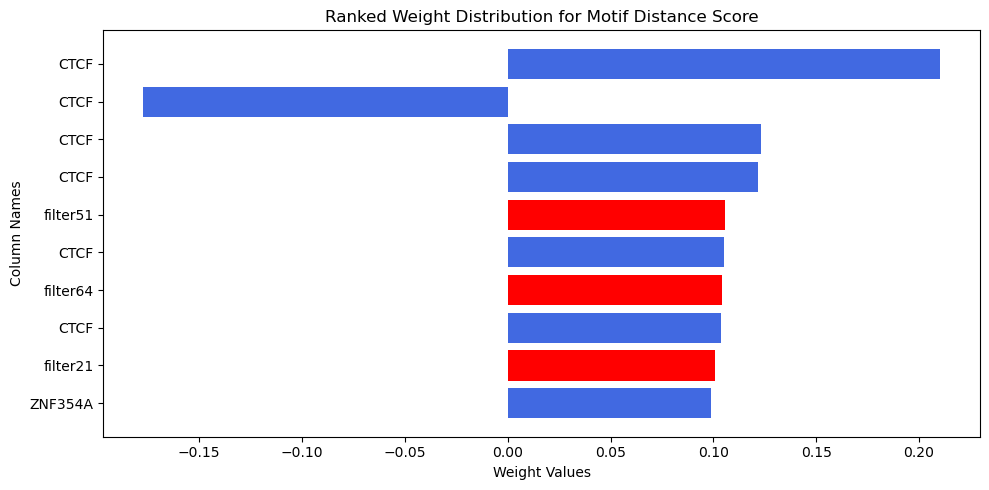

In [46]:
### Plot Bar Plots of Filter Weight Values
plot_filter_weight(weight_df, top_n=10)


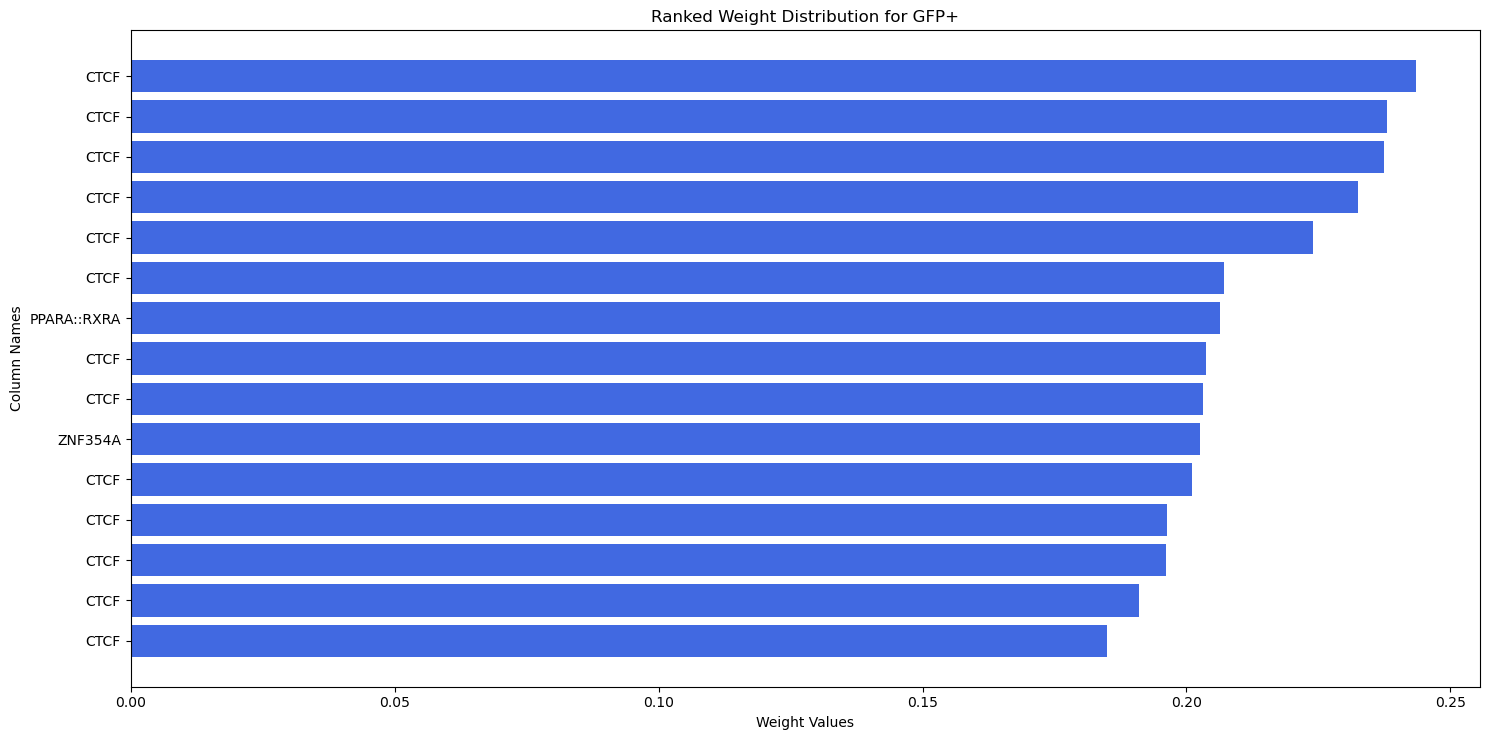

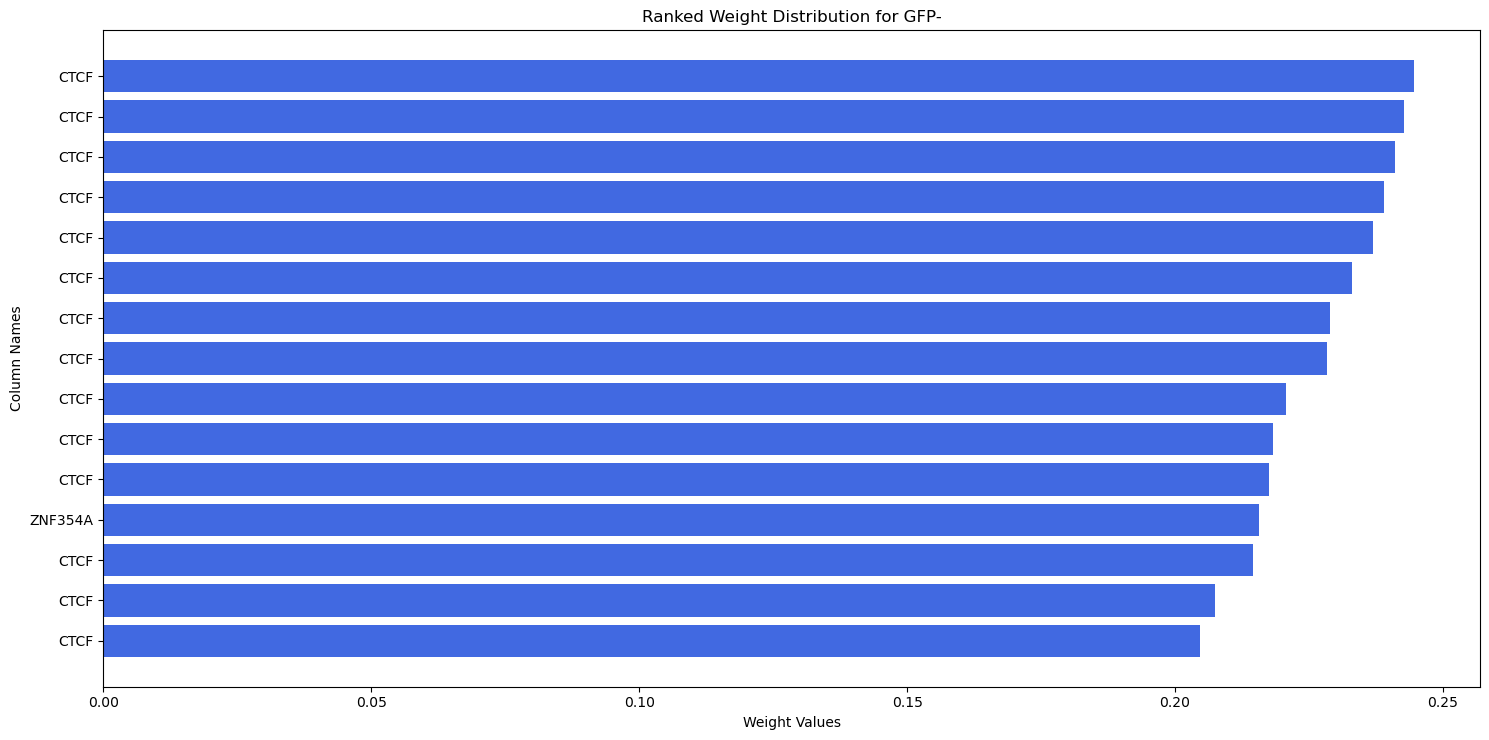

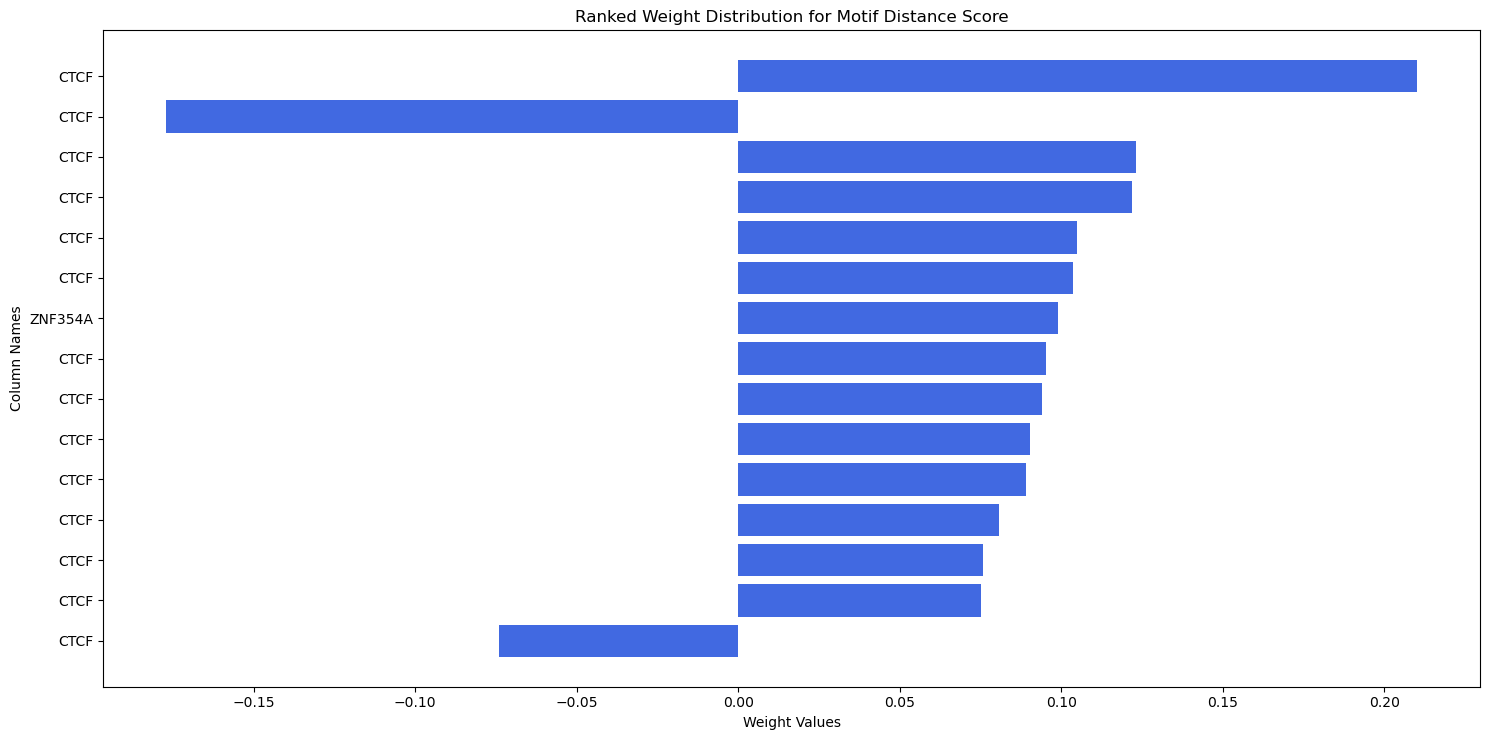

In [48]:
# Remove columns that does not have annotations
ann_wdf = weight_df.loc[:,["filter" not in i for i in list(weight_df)]]

plot_filter_weight(ann_wdf, top_n=15)


In [14]:
# Assuming 'interpretation' and 'explainn' are already defined and properly configured
# Also assuming 'data_loader', 'device', and 'annotation' are defined as per your setup

unit_importance_GFP_pos = []
unit_importance_GFP_neg = []
unit_importance_motif_dist_score = []
unit_names = []
tf_to_filter = {}

# Loop through units with indices 0 to 4
for unit_index in range(num_cnns):
    filter_key = "filter" + str(unit_index)
    title = annotation[filter_key] if filter_key in annotation.index else filter_key
    tf_to_filter[title] = filter_key
    unit_names.append(title)  # Store the unit name for plotting
    
    # Calculate unit importance for the current unit
    unit_outputs = interpretation.get_explainn_unit_outputs(data_loader, explainn, device)
    target_labels = ['GFP+','GFP-','Motif Distance Score']
    importance = interpretation.get_specific_unit_importance(activations, explainn, unit_outputs, unit_index, target_labels)
    unit_importance_GFP_pos.append(importance['GFP+'])
    unit_importance_GFP_neg.append(importance['GFP-'])
    unit_importance_motif_dist_score.append(importance['Motif Distance Score'])



['filter35', 'filter38', 'filter87', 'filter40', 'filter88', 'filter87', 'filter87', 'filter87', 'filter87', 'filter52']
['filter88', 'filter87', 'filter87', 'filter68', 'filter87', 'filter87', 'filter55', 'filter87', 'filter87', 'filter87']
['filter87', 'filter87', 'filter87', 'filter87', 'filter87', 'filter13', 'filter87', 'filter87', 'filter87', 'filter86']


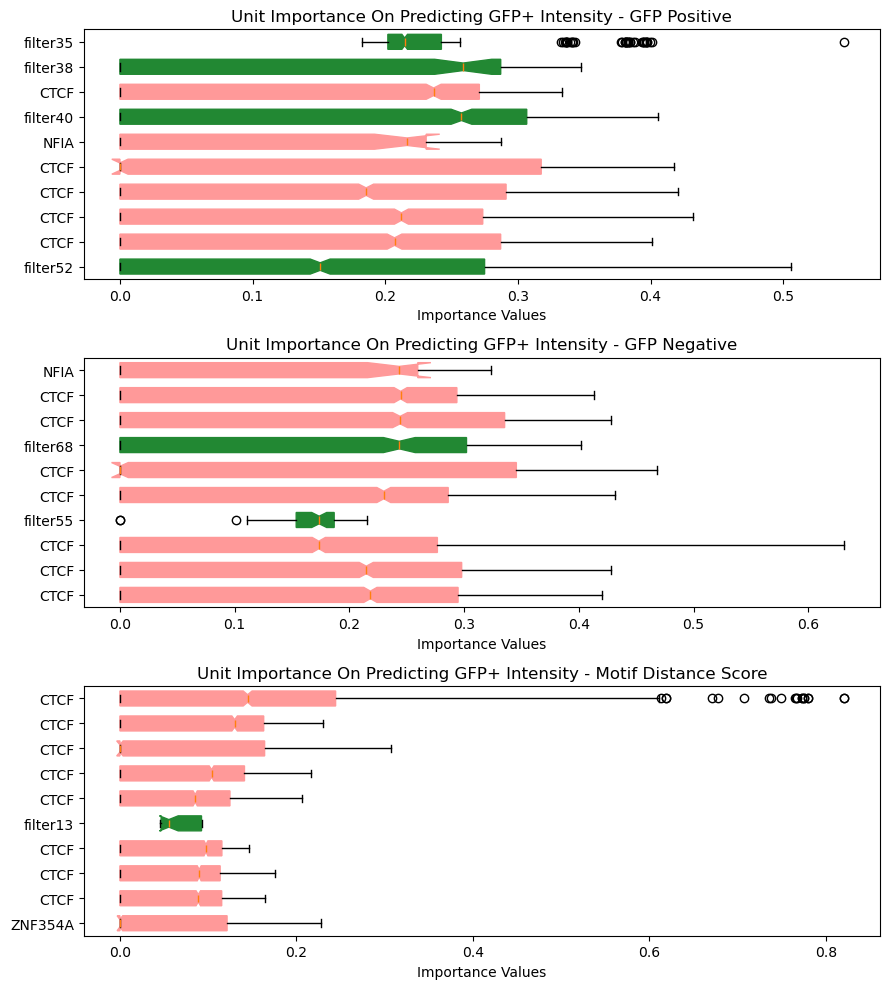

In [49]:
"""Plot the Ranked Importance Value of Each Filter"""
num_filter_plot = 10
# Create a list to store common important filters
common_filters = []

def plot_importance(ax, unit_importance_values, title_suffix):
    # Calculate the means of each list in unit_importance_values
    means = [np.mean(values) for values in unit_importance_values]

    # Create tuples of means, unit names, and values, then sort them by means
    sorted_data = sorted(zip(means, unit_names, unit_importance_values), key=lambda x: x[0], reverse=True)

    # Unzip the sorted data
    sorted_means, sorted_names, sorted_values = zip(*sorted_data)

    # Print top 10 most impoertant filters
    values_list = [tf_to_filter[name] for name in sorted_names[:10] if name in tf_to_filter]
    common_filters.append(values_list)
    print(values_list)

    # Unzip the sorted data
    sorted_means, sorted_names, sorted_values = zip(*sorted_data[:num_filter_plot][::-1])

    # Define properties for outliers (fliers)
    flierprops = dict(marker='o', color='black', markersize=6)

    # Create box plots individually to control colors
    box_width = 0.6  # Set box width
    for i, (name, data) in enumerate(zip(sorted_names, sorted_values)):
        color = "#ff9999" if "filter" not in name.lower() else "#228833"
        ax.boxplot(data, positions=[i + 1], widths=box_width, notch=True, patch_artist=True,vert=False,
                   boxprops=dict(facecolor=color, color=color), flierprops=flierprops)

    # Set custom sorted x-axis labels
    ax.set_yticks(range(1, len(sorted_names) + 1))
    ax.set_yticklabels(sorted_names, rotation=0)
    ax.set_title(f"Unit Importance On Predicting GFP+ Intensity - {title_suffix}")
    ax.set_xlabel("Importance Values")

# Create a figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 10))  # Adjust size as necessary

# Plot for GFP+ positive
plot_importance(ax1, unit_importance_GFP_pos, "GFP Positive")

# Plot for GFP+ negative
plot_importance(ax2, unit_importance_GFP_neg, "GFP Negative")

# Plot for Motif Distance Score
plot_importance(ax3, unit_importance_motif_dist_score, "Motif Distance Score")

plt.tight_layout()
plt.show()



In [ ]:
# Assuming common_filters contains exactly three lists
list1, list2, list3 = common_filters

# Convert lists to sets and find the intersection
common_elements = set(list1) & set(list2) & set(list3)

# Convert the set back to a list if needed
common_elements_list = list(common_elements)

print(common_elements_list)

In [10]:

def get_specific_unit_importance(activations, model, unit_outputs, filt, target_labels):
    """
    Function to compute unit importance (unit_output*class weight) of a particular ExplaiNN unit (indexed at filt)
    :param activations: numpy.array, matrix of activations of shape (N, U, S); N - size of the dataset;
    U - number of units; S - size of the activation map
    :param model: ExplaiNN model
    :param unit_outputs: numpy.array, outputs of individual units, shape (N, U); N - size of the dataset; U - number of units;
    :param filt: int, index of the unit of interest;
    :param target_labels: a list with the names of the output nodes;
    :return: pandas.Series, contains O keys (number of ExplaiNN outputs, labels), each key contains an array of size X,
    where X is equal to the number of sequences that activated the unit of interest (indexed at filt) more than an
    activation threshold
    """

    activation_threshold = 0.5 * np.amax(activations, axis=(0, 2))
    print(f"activation_threshold shape: {activation_threshold.shape}")
    print(f"activation shape: {activations.shape}")

    # sequences (their indeces) that highly activated the filter
    res = {}
    for i in range(activation_threshold.shape[0]):
        if i != filt: continue # focus on current unit
        inds = []
        print(f"current filter is filter{filt}")
        for j in range(activations.shape[0]):
            # For 590 features at jth sample in the ith cnn, find indices of features that are activated 
            indices = np.where(activations[j, i, :] > activation_threshold[i])
            if indices[0].shape[0] > 0:
                inds.append(j)
        res[i] = inds # inds contains index of samples that have at least 1 activated feature among 590 in the specified cnn filter
    

    weights = model.final.weight.detach().cpu().numpy()  # -0.035227 0.480355
    print(f"weights shape {weights.shape}")

    res_distr = {}
    for cl in range(len(target_labels)):
        # 
        f_cell = np.multiply(unit_outputs, weights[cl])
        print(f'For label {target_labels[cl]}')
        print(f'final cell shape after multiplying cnn outputs [sample, num_cnn] with weight [1, num_cnn]: {f_cell.shape}')
        res_distr[target_labels[cl]] = f_cell[:, filt]
        print(f'interested filter final cell shape" {res_distr[target_labels[cl]].shape}')
        print(f'interested filter final cell sum" {np.sum(res_distr[target_labels[cl]])}')
        res_distr[target_labels[cl]] = res_distr[target_labels[cl]][res[filt]]
        print(f'After removing samples dont have any activated features: {res_distr[target_labels[cl]].shape}')

    res_distr = pd.Series(res_distr)

    return res_distr
# unit_outputs are the output 90 feature values for each sample from ExplaiNN linears layer (before final layer) 
unit_outputs = interpretation.get_explainn_unit_outputs(data_loader, explainn, device)
print(unit_outputs.shape)
target_labels = ['GFP+','GFP-','Motif Distance Score']
importance = get_specific_unit_importance(activations, explainn, unit_outputs, 55, target_labels)
print(f'importance shape: {importance.shape}')
importance

(6676, 90)
activation_threshold shape: (90,)
activation shape: (6676, 90, 590)
current filter is filter55
weights shape (3, 90)
For label GFP+
final cell shape after multiplying cnn outputs [sample, num_cnn] with weight [1, num_cnn]: (6676, 90)
interested filter final cell shape" (6676,)
interested filter final cell sum" 530.7913818359375
After removing samples dont have any activated features: (63,)
For label GFP-
final cell shape after multiplying cnn outputs [sample, num_cnn] with weight [1, num_cnn]: (6676, 90)
interested filter final cell shape" (6676,)
interested filter final cell sum" 828.2066650390625
After removing samples dont have any activated features: (63,)
For label Motif Distance Score
final cell shape after multiplying cnn outputs [sample, num_cnn] with weight [1, num_cnn]: (6676, 90)
interested filter final cell shape" (6676,)
interested filter final cell sum" -68.36231994628906
After removing samples dont have any activated features: (63,)
importance shape: (3,)


GFP+                    [0.07115021, 0.11050957, 0.12764533, 0.1196912...
GFP-                    [0.11101742, 0.17243077, 0.19916813, 0.1867571...
Motif Distance Score    [-0.009163664, -0.01423288, -0.016439851, -0.0...
dtype: object

ZNF354A/CTCF


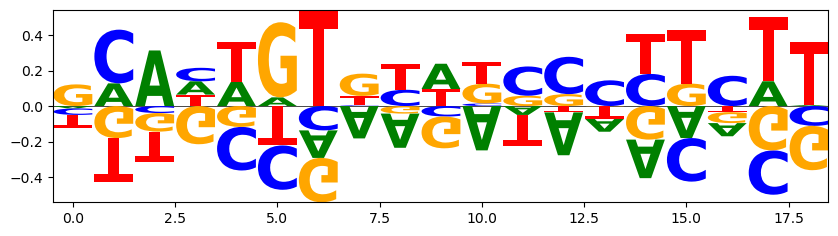

In [27]:
# Generate Motif Logos for top important filter PWMs
motifs, motif_names = tools.read_meme('/pmglocal/ty2514/Enhancer/Enhancer/data/90CNN_distance_TFBS.meme')

filterid=86
# For distance score prediction: ['filter84', 'filter34', 'filter14', 'filter73', 'filter31', 'filter13', 'filter22', 'filter60', 'filter67', 'filter86']

x = [list(i) for i in motifs[filterid]]
pwm = tools._PWM_to_filter_weights(x, filter_size)
nn_logo = logomaker.Logo(pd.DataFrame(data=pwm,columns = ["A","C", "G","T"]))
if ('filter' + str(filterid)) in annotation:
    print(annotation['filter' + str(filterid)])
else:
    print("filter not annotated")

In [ ]:
filterid=59
# For distance score prediction: ['filter42', 'filter44', 'filter52', 'filter56', 'filter33', 'filter75', 'filter28', 'filter6', 'filter14', 'filter59']
x = [list(i) for i in motifs[filterid]]
pwm = tools._PWM_to_filter_weights(x, filter_size)
nn_logo = logomaker.Logo(pd.DataFrame(data=pwm,columns = ["A","C", "G","T"]))
if ('filter' + str(filterid)) in annotation:
    print(annotation['filter' + str(filterid)])
else:
    print("filter not annotated")# motif1 = 'GCGGG'
# motif2 = 'CATCT'

### Motif Clustering Plotting

In [50]:
# Load the similarity matrix
from scipy.cluster.hierarchy import linkage

data = np.load('/pmglocal/ty2514/Enhancer/Enhancer/tomtom_2024results/90NN_distance_clustering/similarities.npz')
similarity_matrix = data['similarities']  # adjust the key if different
# Generate the linkage matrix
distance_matrix = 10.0 - similarity_matrix
Z = linkage(distance_matrix, method='complete')
Z.shape


/tmp/ipykernel_907015/580695937.py:8: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='complete')


(89, 4)

/tmp/ipykernel_907015/629971919.py:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='complete')


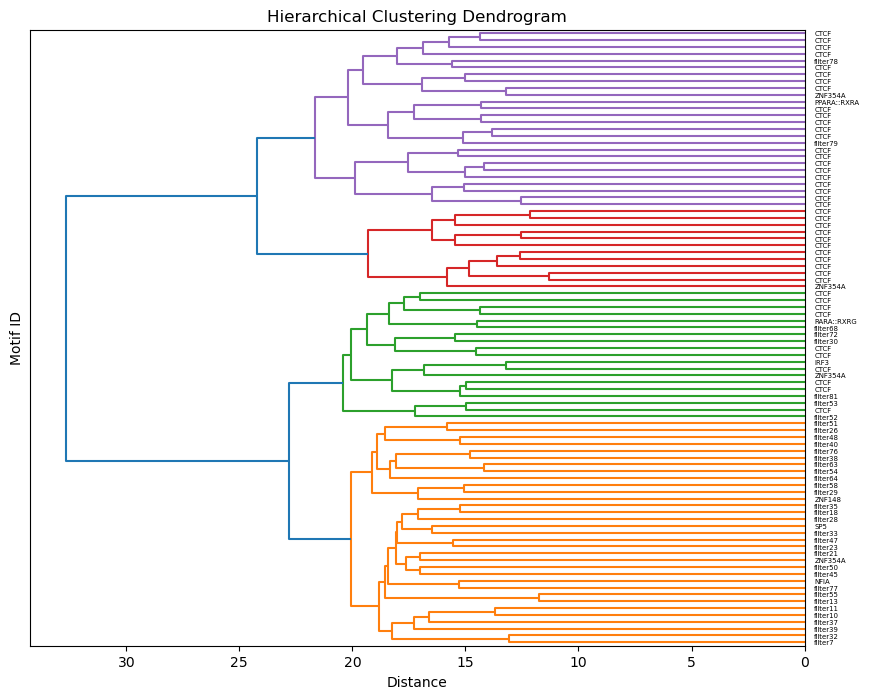

In [51]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
# Generate the linkage matrix
distance_matrix = 10.0 - similarity_matrix
Z = linkage(distance_matrix, method='complete')

# Load motif names
clusters = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/tomtom_2024results/90NN_distance_clustering/clusters.tsv', sep='\t')
motif_names = clusters['Motif_ID'].values
# Replace motif names with annotated ones if the annotation exists
for i in range(len(motif_names)):
    if motif_names[i] in annotation.keys():
        motif_names[i] = annotation[motif_names[i]]

plt.figure(figsize=(10, 8))
dendrogram(Z, orientation='left', labels=motif_names, color_threshold=22)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Distance')
plt.ylabel('Motif ID')
plt.show()

/tmp/ipykernel_907015/3513177465.py:14: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, 'ward')


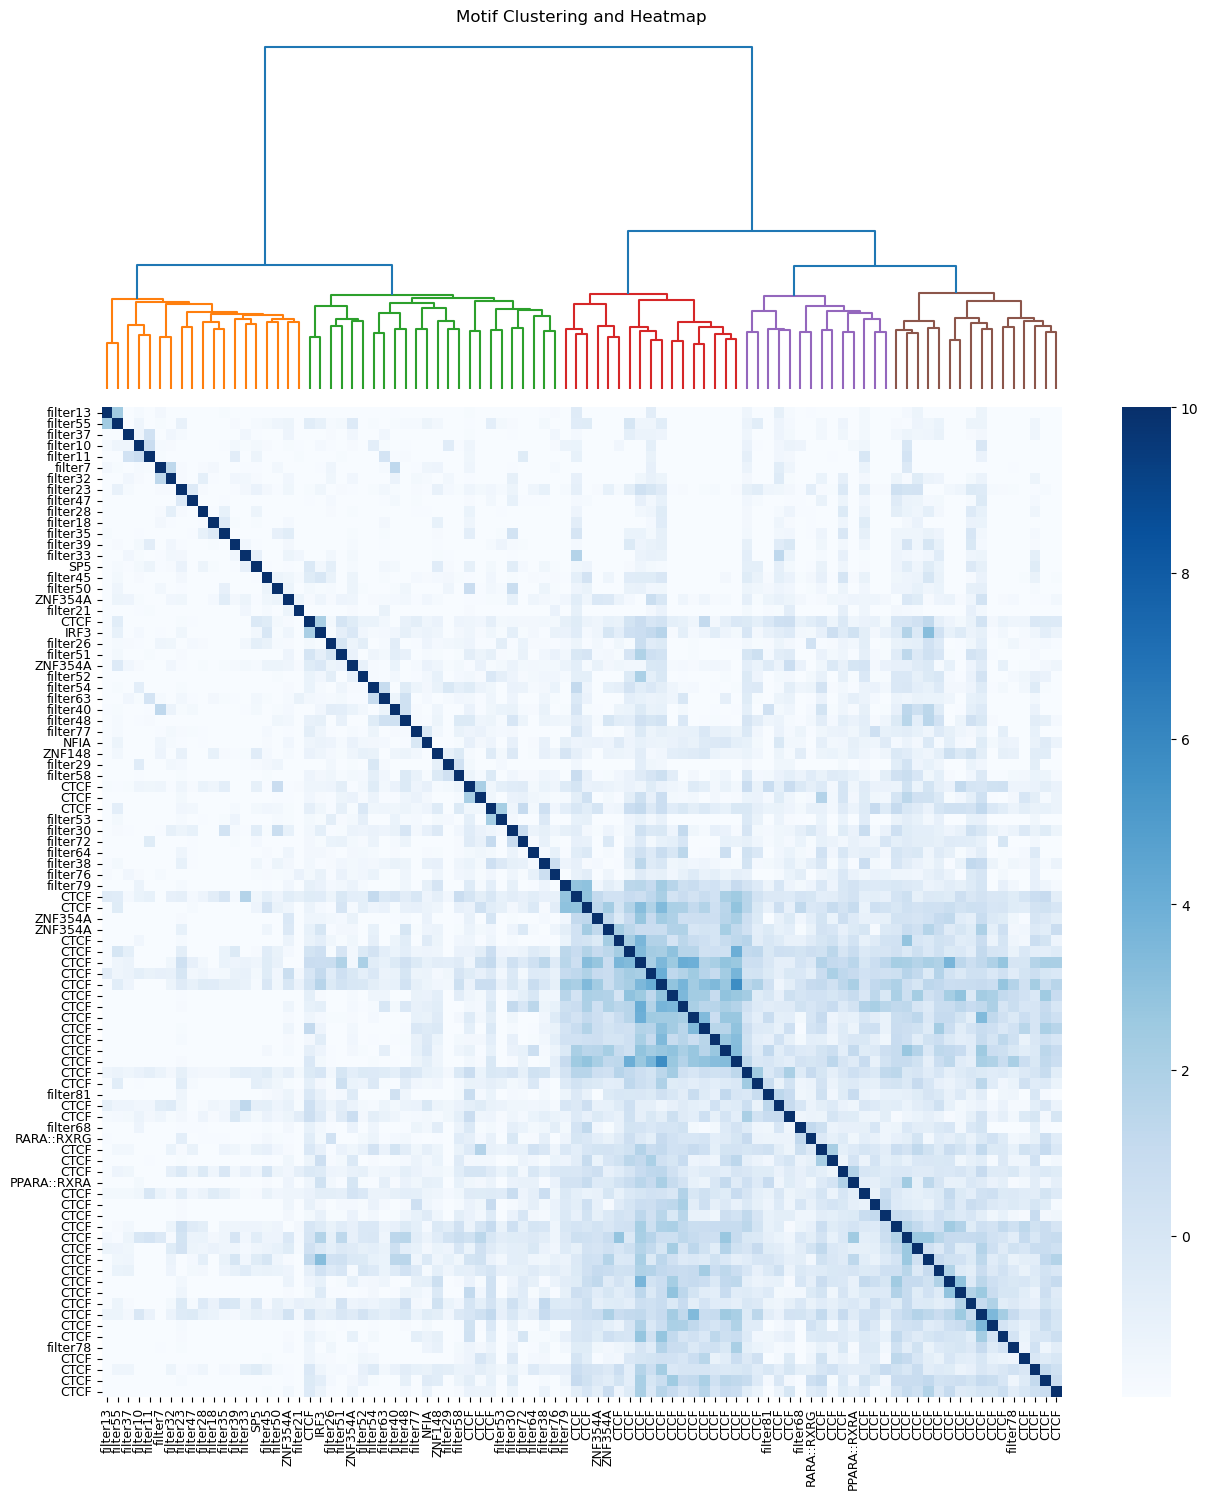

In [52]:
# Load data and process as previously described
clusters = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/tomtom_2024results/90NN_distance_clustering/clusters.tsv', sep='\t')
motif_names = clusters['Motif_ID'].values

# Replace motif names with annotated ones if the annotation exists
for i in range(len(motif_names)):
    if motif_names[i] in annotation.keys():
        motif_names[i] = annotation[motif_names[i]]

# Convert similarity to distance
distance_matrix = 10 - similarity_matrix  # Assuming max value in similarity_matrix is 10

# Generate linkage matrix
Z = linkage(distance_matrix, 'ward')

# Prepare figure
fig = plt.figure(figsize=(12, 18))

# Create dendrogram on top
ax1 = fig.add_axes([0.1, 0.66, 0.8, 0.2])  # position: [left, bottom, width, height]
dendro = dendrogram(Z, orientation='top', labels=motif_names, color_threshold=25)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_title('Motif Clustering and Heatmap')


# Extract order of leaves after dendrogram
idx = dendro['leaves']

# Reorder data and labels according to dendrogram
data_ordered = similarity_matrix[idx, :][:, idx]
motif_names_ordered = np.array(motif_names)[idx]

# Create heatmap below the dendrogram
ax2 = fig.add_axes([0.1, 0.1, 1, 0.55])  # Match the horizontal positioning with dendrogram
sns.heatmap(data_ordered, ax=ax2, xticklabels=motif_names_ordered, yticklabels=motif_names_ordered, cmap='Blues')
ax2.tick_params(axis='x', rotation=90,labelsize=9)  # Rotate x labels for better visibility
ax2.tick_params(axis='y', labelsize=9)  # Rotate x labels for better visibility

plt.show()


### Annotate Cluster PWMs

In [ ]:
tomtom_results = pd.read_csv("/pmglocal/ty2514/Enhancer/Enhancer/tomtom_2024results/tomtom_CAM_90NN_distance_clusters/tomtom.tsv",
                                        sep="\t",comment="#")
filters_with_min_q = tomtom_results.groupby('Query_ID').min()["q-value"]
tomtom_results = tomtom_results[["Target_ID", "Query_ID", "q-value"]]
tomtom_results = tomtom_results[tomtom_results["q-value"]<0.05]
cisbp_motifs = {}
with open("/pmglocal/ty2514/Enhancer/ExplaiNN/data/JASPAR/JASPAR2024_CORE_vertebrates_non-redundant_pfms_meme.txt") as f:
    for line in f:
        if "MOTIF" in line:
            motif = line.strip().split()[-1]
            name_m = line.strip().split()[-2]
            cisbp_motifs[name_m] = motif

filters = tomtom_results["Query_ID"].unique()
annotation = {}
for f in filters:
    t = tomtom_results[tomtom_results["Query_ID"] == f]
    target_id = t["Target_ID"]
    if len(target_id) > 5:
        target_id = target_id[:5]
    ann = "/".join([cisbp_motifs[i] for i in target_id.values])
    annotation[f] = ann

annotation = pd.Series(annotation)
annotation